In [1]:
%load_ext autoreload
%autoreload 2

# LDLS Demo

This notebook demonstrates how to use LDLS to perform instance segmentation of a LiDAR point cloud. This demo uses Frame 571 from the KITTI object detection dataset.

## Setup

Import LiDAR segmentation modules:

In [2]:
import numpy as np
from pathlib import Path
import skimage

from lidar_segmentation.detections import MaskRCNNDetections
from lidar_segmentation.segmentation import LidarSegmentation
from lidar_segmentation.kitti_utils import load_kitti_lidar_data, load_kitti_object_calib
from lidar_segmentation.utils import load_image
from mask_rcnn.mask_rcnn import MaskRCNNDetector


Using TensorFlow backend.


# Load input data

Load the following files:
- Calibration data (relates the LiDAR and camera sensor coordinate frames)
- Image
- LiDAR point cloud

Loaded LiDAR point cloud with 123131 points


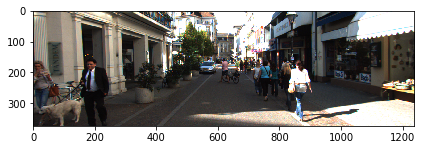

In [3]:
# Define file paths
calib_path = Path("data/") / "kitti_demo" / "calib" / "000571.txt"
image_path = Path("data/") / "kitti_demo" / "image_2" / "000571.png"
lidar_path = Path("data/") / "kitti_demo" / "velodyne" / "000571.bin"

# Load calibration data
projection = load_kitti_object_calib(calib_path)

# Load image
image = load_image(image_path)
skimage.io.imshow(image)

# Load lidar
lidar = load_kitti_lidar_data(lidar_path, load_reflectance=False)
print("Loaded LiDAR point cloud with %d points" % lidar.shape[0])

# Run Mask-RCNN detector on image

The first step in the LDLS pipeline is to run Mask-RCNN on the input image to generate 2D segmentation masks. The following code block runs Mask-RCNN and visualizes results on the input image.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/bhw45/anaconda3/envs/ldls_2/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


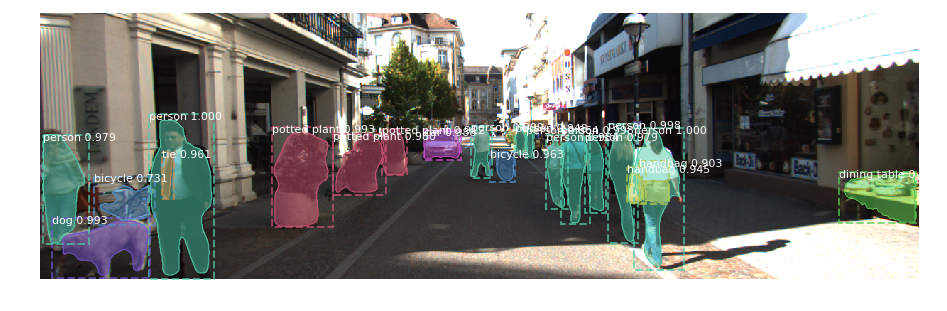

In [4]:
detector = MaskRCNNDetector()
detections = detector.detect(image)
detections.visualize(image)

# Perform LiDAR segmentation

Next, perform 3D segmentation using a LidarSegmentation object. The LidarSegmentation.run() method takes as inputs a LiDAR point cloud, Mask-RCNN detections, and a maximum number of iterations parameter.

In [7]:
lidarseg = LidarSegmentation(projection)
# Be sure to set save_all=False when running segmentation
# If set to true, returns label diffusion results at each iteration in the results
# This is useful for analysis or visualizing the diffusion, but slow.
results = lidarseg.run(lidar, detections, max_iters=50, save_all=False)

In [6]:
%timeit lidarseg.run(lidar, detections, max_iters=50, save_all=False)

363 ms ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Visualize results using Plotly

Plot the resulting labeled pointcloud using [Plotly](https://plot.ly/). You can visualize the results with points colored according to class labels (Person, Car, ...), or instance labels (Person 1, Person 2, Car 1, ...).

In [ ]:
from lidar_segmentation.plotting import plot_segmentation_result

# Show points colored by class label
plot_segmentation_result(results, label_type='class')

In [ ]:
# Show points colored by instance label
plot_segmentation_result(results, label_type='instance')

You can also visualize the label diffusion over time. This requires running the lidar segmentation with the `save_all` parameter set to `true` (note that this is significantly slower due to saving the full diffusion results in an array).

Run the following code block to visualize this. You can use the slide bar on the bottom to see results at different iterations.

In [ ]:
from lidar_segmentation.plotting import plot_diffusion

results_all = lidarseg.run(lidar, detections, max_iters=50, save_all=True)
plot_diffusion(results_all)